<a href="https://colab.research.google.com/github/shestakovm/CartPole/blob/master/CartPole_TF_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,131 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
num_iterations = 20000 

initial_collect_steps = 100  
collect_steps_per_iteration = 1   
replay_buffer_max_length = 100000  

batch_size = 64  
learning_rate = 0.001  
log_interval = 200 

num_eval_episodes = 10
eval_interval = 1000

In [ ]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

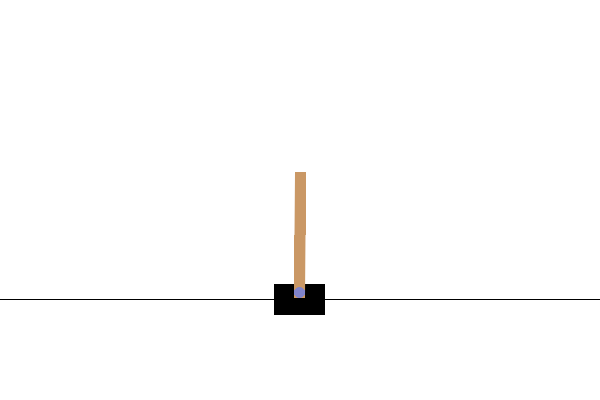

In [ ]:
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
print('Observation spec:')
print(env.time_step_spec().observation)

In [ ]:
print('reward spec')
print(env.time_step_spec().reward)

reward spec
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [ ]:
print('action spec:')
print(env.action_spec())

action spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [ ]:
time_step = env.reset()
print('time step:')
print(time_step)

action = np.array(1, dtype=np.int32)
next_time_step = env.step(action)
print('next time step')
print(next_time_step)

time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.03403301,  0.01027308, -0.01390739, -0.02852556], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
next time step
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.03382755,  0.20559168, -0.0144779 , -0.32556376], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
fc_layer_param = (100,50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

In [ ]:
def dense(num_units):
  return tf.keras.layers.Dense(units = num_units, activation = 'relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))


In [ ]:
dense_layer = [dense(num_units) for num_units in fc_layer_param]
q_values_layer = tf.keras.layers.Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03), bias_initializer=tf.keras.initializers.Constant(-0.2))

In [ ]:
q_net = sequential.Sequential(dense_layer + [q_values_layer])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(train_env.time_step_spec(),train_env.action_spec(), 
                           q_network = q_net, optimizer = optimizer,
                           td_errors_loss_fn = common.element_wise_squared_loss,
                           train_step_counter=train_step_counter)

agent.initialize()

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))

In [ ]:
time_step = example_environment.reset()

In [ ]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [ ]:
def compute_avg_return(environment, policy, num_episodes = 10):
  total_return = 0.0
  for n in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return +=episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

19.7

In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(table_name, max_size=replay_buffer_max_length, sampler=reverb.selectors.Uniform(),
                     remover=reverb.selectors.Fifo(), rate_limiter=reverb.rate_limiters.MinSize(1),
                     signature=replay_buffer_signature)
reverb_server = reverb.Server([table])
replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(agent.collect_data_spec, table_name=table_name,
                                                        sequence_length =2, local_server = reverb_server)
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(replay_buffer.py_client, table_name, sequence_length=2)


In [ ]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [ ]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
py_driver.PyDriver(env,py_tf_eager_policy.PyTFEagerPolicy(random_policy, use_tf_function=True), 
                   [rb_observer], max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([ 0.10001346,  0.6109619 , -0.04953569, -0.7202532 ], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}), ())

In [ ]:
dataset = replay_buffer.as_dataset(num_parallel_calls = 3, sample_batch_size = batch_size, num_steps=2).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [ ]:
iterator = iter(dataset)
print(iterator)

тренировка агента

In [ ]:
try:
  %%time
except:
  pass

agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

time_step = train_py_env.reset()

collect_driver = py_driver.PyDriver(env, py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True),
 [rb_observer], max_steps=collect_steps_per_iteration)

for i in range(num_iterations):
  time_step, i = collect_driver.run(time_step)
  expirience, unused_info = next(iterator)
  train_loss = agent.train(expirience).loss
  
  step = agent.train_step_counter.numpy()

  if step% log_interval == 0:
    print('шаг = {0}: ошибка = {1}'.format(step,train_loss))
  if step% eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('шаг = {0}: средний возврат = {1}'.format(step, avg_return))
    returns.append(avg_return)


шаг = 200: ошибка = 318061.21875
шаг = 400: ошибка = 5900.64990234375
шаг = 600: ошибка = 263692.28125
шаг = 800: ошибка = 6856.23681640625
шаг = 1000: ошибка = 3240.32568359375
шаг = 1000: средний возврат = 200.0
шаг = 1200: ошибка = 13069.689453125
шаг = 1400: ошибка = 3829.72509765625
шаг = 1600: ошибка = 816.5556030273438
шаг = 1800: ошибка = 1667.3050537109375
шаг = 2000: ошибка = 1660.353271484375
шаг = 2000: средний возврат = 200.0
шаг = 2200: ошибка = 844.78515625
шаг = 2400: ошибка = 1617.0079345703125
шаг = 2600: ошибка = 494.42486572265625
шаг = 2800: ошибка = 862.6232299804688
шаг = 3000: ошибка = 455.92083740234375
шаг = 3000: средний возврат = 200.0
шаг = 3200: ошибка = 755.5277099609375
шаг = 3400: ошибка = 522.607666015625
шаг = 3600: ошибка = 1011.4451293945312
шаг = 3800: ошибка = 1240.401611328125
шаг = 4000: ошибка = 673.7269897460938
шаг = 4000: средний возврат = 200.0
шаг = 4200: ошибка = 1817.9886474609375
шаг = 4400: ошибка = 1885.0980224609375
шаг = 4600: ошибк

(194.6449935913086, 250.0)

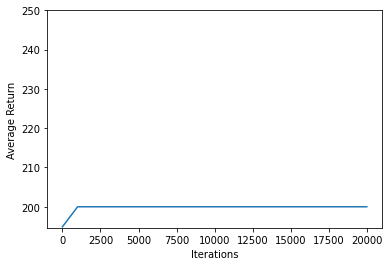

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")